# Integration tests for interleaved filter/smoother

[Durbin and Koopman (2000)](http://onlinelibrary.wiley.com/doi/10.1111/1467-9892.00186/abstract) and Durbin and Koopman (2012) section 6.4 showed that a method of interleaving vector observations to create a univariate series avoided matrix inversion and resulted in a large computational speedup.

**Important**: This method assumes that $\varepsilon_t \sim \mathcal{N}(0, H_t)$ with $H_t$ diagonal!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sstools as ss
%matplotlib inline
sns.set_style('darkgrid')

# Let's generate some data from a state space model

In [2]:
np.random.seed(12345)  # set random seed

In [3]:
Z = np.array([[1, -1], [0, 1], [1, 0]])  # observation matrix
H = 0.1 * np.array([[1, 0, 0], [0, 1.2, 0], [0, 0, 1.5]])

Np, Nm = Z.shape

th = 10 * np.pi / 180  # rotation angle
T = np.array([[np.cos(th), np.sin(th)], [-np.sin(th), np.cos(th)]])  # rotation matrix
R = np.array([1.1, 1])[:, np.newaxis]
Q = np.array([0.05])[:, np.newaxis]

_, Nr = R.shape

a_init = np.zeros(Nm)
P_init = 5 * np.eye(Nm)

## Now generate some data

In [4]:
Nt = 100  # number of samples

Preallocate data arrays:

In [5]:
alpha = np.empty((Nt, Nm))
y = np.empty((Nt, Np))
eps = np.empty((Nt, Np))
eta = np.empty((Nt, Nr))

Initialize:

In [6]:
alpha[0] = np.random.multivariate_normal(a_init, P_init)

In [7]:
for t in range(Nt):
    eps[t] = np.random.multivariate_normal(np.zeros(Np), H)
    eta[t] = np.random.multivariate_normal(np.zeros(Nr), Q)
    y[t] = Z.dot(alpha[t]) + eps[t]
    if t + 1 < Nt:
        alpha[t + 1] = T.dot(alpha[t]) + R.dot(eta[t])

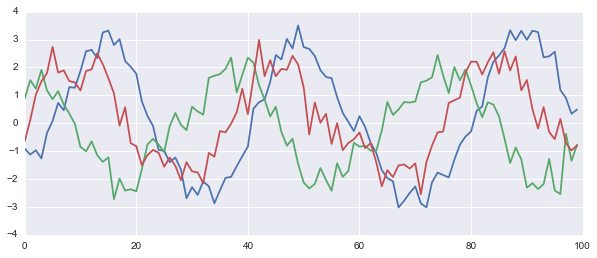

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(y);

# Kalman filter

In [9]:
# test for diagonality of H
# H (minus its diagonals) should be the 0 matrix
assert(np.all(H - np.diag(np.diag(H)) == 0))

In [10]:
Nt, Np = y.shape
Nm = P_init.shape[0]

# preallocate
a = np.empty((Nt, Np + 1, Nm))
P = np.empty((Nt, Np + 1, Nm, Nm))
v = np.empty((Nt, Np))
F = np.empty((Nt, Np))
K = np.empty((Nt, Np, Nm))

In [11]:
from itertools import product

# initialize
a[0, 0] = a_init
P[0, 0] = P_init

# iterate
for t, i in product(range(Nt), range(Np)):
    v[t, i] = y[t, i] - Z[i].dot(a[t, i])
    F[t, i] = Z[i].dot(P[t, i]).dot(Z[i]) + H[i, i]
    Finv = 1 / F[t, i]
    if F[t, i] != 0:
        K[t, i] = P[t, i].dot(Z[i]) * Finv
    else:
        K[t, i] = 0
    
    a[t, i + 1] = a[t, i] + K[t, i] * v[t, i]
    P[t, i + 1] = P[t, i] - K[t, i].dot(K[t, i]) * F[t, i]
    
    if t + 1 < Nt and i == Np - 1:
        a[t + 1, 0] = T.dot(a[t, Np])
        P[t + 1, 0] = T.dot(P[t, Np]).dot(T.T) + R.dot(Q).dot(R.T)

In [14]:
v[0, 0]

-0.90705570446820372

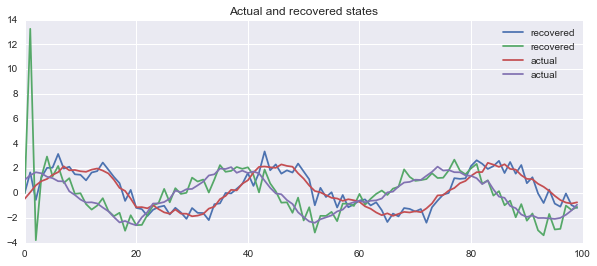

In [20]:
plt.figure(figsize=(10, 4))
plt.plot(a[:, 0, :], label='recovered')
plt.plot(alpha, label='actual')
plt.title('Actual and recovered states')
plt.legend()
pass

In [21]:
a[:, 0, :]

array([[  0.00000000e+00,   0.00000000e+00],
       [  1.68109426e+00,   1.32547497e+01],
       [ -5.41914171e-01,  -3.79138321e+00],
       [  1.27446087e+00,   1.32994503e+00],
       [  2.04172902e+00,   2.95508742e+00],
       [  2.05995382e+00,   1.35649034e+00],
       [  3.16452670e+00,   2.19492888e+00],
       [  1.98702171e+00,   8.26255181e-01],
       [  2.13542871e+00,   1.21148740e+00],
       [  1.52521260e+00,  -5.45051609e-02],
       [  1.48305280e+00,  -1.47387558e-03],
       [  1.03616382e+00,  -8.78118343e-01],
       [  1.66700934e+00,  -1.32167760e+00],
       [  1.78143399e+00,  -9.99220576e-01],
       [  2.47326803e+00,  -4.03252087e-01],
       [  1.89746017e+00,  -1.42940240e+00],
       [  1.30973840e+00,  -1.85273304e+00],
       [  8.08973198e-01,  -1.57804901e+00],
       [ -6.21793653e-01,  -3.02682178e+00],
       [  2.66682118e-01,  -1.77761430e+00],
       [ -1.18163249e+00,  -2.57634181e+00],
       [ -1.28487141e+00,  -2.55681407e+00],
       [ -